# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../files/Udacity_AZDIAS_052018.csv', sep=';', dtype='object')
customers = pd.read_csv('../files/Udacity_CUSTOMERS_052018.csv', sep=';', dtype='object')

In [3]:
azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9,0,NaN,NaN,NaN,NaN,21,11,...,4,8,11,10,3,9,4,5,2,1
2,910225,-1,9,17,NaN,NaN,NaN,NaN,17,10,...,2,9,9,6,3,9,2,5,2,3
3,910226,2,1,13,NaN,NaN,NaN,NaN,13,1,...,0,7,10,11,NaN,9,7,3,2,4
4,910241,-1,1,20,NaN,NaN,NaN,NaN,14,3,...,2,3,5,4,2,9,3,4,1,3
5,910244,3,1,10,NaN,NaN,NaN,NaN,10,5,...,2,10,7,4,6,9,7,4,2,1
6,910248,-1,9,0,NaN,NaN,NaN,NaN,NaN,4,...,2,7,10,10,3,9,5,4,2,2
7,910261,-1,1,14,NaN,NaN,NaN,NaN,14,6,...,2,10,12,9,5,9,1,1,1,1
8,645145,-1,9,16,NaN,NaN,NaN,NaN,16,2,...,4,8,11,8,5,8,1,6,1,3
9,645153,-1,5,17,NaN,NaN,NaN,NaN,17,9,...,4,1,1,1,4,3,7,4,2,3


In [4]:
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1,10,NaN,NaN,NaN,NaN,10,1,...,2,6,9,7,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9,11,NaN,NaN,NaN,NaN,NaN,NaN,...,3,0,9,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1,6,NaN,NaN,NaN,NaN,0,1,...,11,6,9,2,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1,8,NaN,NaN,NaN,NaN,8,0,...,2,NaN,9,7,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1,20,NaN,NaN,NaN,NaN,14,7,...,4,2,9,3,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1,11,NaN,NaN,NaN,NaN,10,1,...,1,6,9,1,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1,10,NaN,NaN,NaN,NaN,10,1,...,2,6,9,7,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1,10,NaN,NaN,NaN,NaN,9,1,...,1,6,9,3,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3,5,NaN,NaN,NaN,NaN,4,74,...,9,6,3,4,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1,20,NaN,NaN,NaN,NaN,13,1,...,4,2,9,5,1,COSMETIC,MULTI_BUYER,0,1,3


In [5]:
excel_file = pd.read_excel('../files/DIAS Attributes - Values 2017.xlsx', sheet_name='Tabelle1', header=1, usecols=[1,2,3,4],
                          dtype='object')
excel_file = excel_file.fillna(method='ffill')
excel_file.Attribute = excel_file.Attribute.str.upper().str.strip()
excel_file.Meaning = excel_file.Meaning.str.lower().str.strip()
excel_file

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart
2254,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,ZABEOTYP,typification of energy consumers,4,price driven
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation


In [6]:
customers.CUSTOMER_GROUP.value_counts()/customers.shape[0]

MULTI_BUYER     0.68999
SINGLE_BUYER    0.31001
Name: CUSTOMER_GROUP, dtype: float64

In [7]:
customers.PRODUCT_GROUP.value_counts()/customers.shape[0]

COSMETIC_AND_FOOD    0.526266
FOOD                 0.247229
COSMETIC             0.226504
Name: PRODUCT_GROUP, dtype: float64

In [8]:
customers.ONLINE_PURCHASE.value_counts()/customers.shape[0]

0    0.909753
1    0.090247
Name: ONLINE_PURCHASE, dtype: float64

In [9]:
(customers.groupby(['CUSTOMER_GROUP','PRODUCT_GROUP'])['CUSTOMER_GROUP'].size()/customers.shape[0]*100).to_frame(name='PERCENTAGE').reset_index()

,CUSTOMER_GROUP,PRODUCT_GROUP,PERCENTAGE
0,MULTI_BUYER,COSMETIC,9.959719
1,MULTI_BUYER,COSMETIC_AND_FOOD,52.626636
2,MULTI_BUYER,FOOD,6.412665
3,SINGLE_BUYER,COSMETIC,12.690710
4,SINGLE_BUYER,FOOD,18.310271


In [10]:
(customers.groupby(['PRODUCT_GROUP','ONLINE_PURCHASE'])['CUSTOMER_GROUP'].size()/customers.shape[0]*100).to_frame(name='PERCENTAGE').reset_index()

,PRODUCT_GROUP,ONLINE_PURCHASE,PERCENTAGE
0,COSMETIC,0,19.893870
1,COSMETIC,1,2.756559
2,COSMETIC_AND_FOOD,0,48.494667
3,COSMETIC_AND_FOOD,1,4.131968
4,FOOD,0,22.586772
5,FOOD,1,2.136163


In [11]:
(customers.groupby(['CUSTOMER_GROUP','PRODUCT_GROUP','ONLINE_PURCHASE'])['CUSTOMER_GROUP'].size()/customers.shape[0]*100).to_frame(name='PERCENTAGE').reset_index()

,CUSTOMER_GROUP,PRODUCT_GROUP,ONLINE_PURCHASE,PERCENTAGE
0,MULTI_BUYER,COSMETIC,0,8.925031
1,MULTI_BUYER,COSMETIC,1,1.034688
2,MULTI_BUYER,COSMETIC_AND_FOOD,0,48.494667
3,MULTI_BUYER,COSMETIC_AND_FOOD,1,4.131968
4,MULTI_BUYER,FOOD,0,5.767746
5,MULTI_BUYER,FOOD,1,0.644919
6,SINGLE_BUYER,COSMETIC,0,10.968839
7,SINGLE_BUYER,COSMETIC,1,1.721871
8,SINGLE_BUYER,FOOD,0,16.819026
9,SINGLE_BUYER,FOOD,1,1.491245


## Check data conformance with documentation

### Documentation check

In [12]:
# Modify column names from D19_* columns from the documentation to drop the pattern "_RZ" to match with the dataframes

excel_file.Attribute = excel_file.Attribute.str.replace(r'\_RZ','')

docs_columns = set(excel_file.Attribute)

def dataframe_conformance(compare_df, documentation_df):
    '''
        Check dataframes structure and compare it to the documentation file.
        
        input:
            compare_df - Dataframe that will be compared
            documentation_df - Documentation Dataframe
        
        output:
            none
    '''
    docs_attributes = set(documentation_df.Attribute)
    
    # Include in documentation attributes the Customer ID: LNR
    docs_attributes.add("LNR")
    
    column_names = set(compare_df.columns)
    diff_docs_comparedf = docs_attributes.difference(column_names)
    diff_comperedf_docs = column_names.difference(docs_attributes)

    print("\n***Comparison between the DF and the documentation data***")
    print("Compared Dataframe Shape: {}".format(compare_df.shape))
    print("\nTot. documentation columns not in DF: {}: \n{}".format(len(diff_docs_comparedf),diff_docs_comparedf))
    print("\nTot. compared df columns not existing in Documentation: {}".format(len(diff_comperedf_docs)))

### AZDIAS Dataframe

In [13]:
dataframe_conformance(azdias, excel_file)


***Comparison between the DF and the documentation data***
Compared Dataframe Shape: (891221, 366)

Tot. documentation columns not in DF: 9: 
{'SOHO_FLAG', 'D19_BUCH', 'D19_KK_KUNDENTYP', 'HAUSHALTSSTRUKTUR', 'BIP_FLAG', 'WACHSTUMSGEBIET_NB', 'CAMEO_DEUINTL_2015', 'GEOSCORE_KLS7', 'KBA13_CCM_1400_2500'}

Tot. compared df columns not existing in Documentation: 60


### CUSTOMERS Dataframe

In [14]:
dataframe_conformance(customers, excel_file)


***Comparison between the DF and the documentation data***
Compared Dataframe Shape: (191652, 369)

Tot. documentation columns not in DF: 9: 
{'SOHO_FLAG', 'D19_BUCH', 'D19_KK_KUNDENTYP', 'HAUSHALTSSTRUKTUR', 'BIP_FLAG', 'WACHSTUMSGEBIET_NB', 'CAMEO_DEUINTL_2015', 'GEOSCORE_KLS7', 'KBA13_CCM_1400_2500'}

Tot. compared df columns not existing in Documentation: 63


### Comparison between AZDIAS and CUSTOMERS DFs

In [15]:
azdias_columns = set(azdias.columns)
customers_columns = set(customers.columns)

azdias_columns ^ customers_columns

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

### Drop columns 

For conformance, and data validation, columns not found in the documentation will be dropped

In [16]:
def drop_columns(df, columns):
    '''
        Drop columns from DF.
        
        input:
            df - Target Dataframe
            columns - Columns to be dropped
        
        output:
            df - Dataframe without dropped columns
            
    '''
    # Keep columns
    skipped_columns = {'LNR'}# {'PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP','LNR'} 
    
    for value in skipped_columns:
        try:
            columns.remove(value)
        except:
            continue
    
    print("Old Dataframe Shape: {}".format(df.shape))
    
    # Drop columns from dataframe
    try:
        df = df.drop(columns=columns)
        print("\nSuccesfully removed {} columns!".format(len(columns)))
    except:
        print("\nError! Check that column names exist in the dataframe")

    return df

In [17]:
# Get column names not existing in the documentation for removal
drop_target_azdias_cols = azdias_columns.difference(docs_columns)

# Remove column names
azdias = drop_columns(azdias, drop_target_azdias_cols)

dataframe_conformance(azdias, excel_file)

azdias.head()

Old Dataframe Shape: (891221, 366)

Succesfully removed 60 columns!

***Comparison between the DF and the documentation data***
Compared Dataframe Shape: (891221, 306)

Tot. documentation columns not in DF: 9: 
{'SOHO_FLAG', 'D19_BUCH', 'D19_KK_KUNDENTYP', 'HAUSHALTSSTRUKTUR', 'BIP_FLAG', 'WACHSTUMSGEBIET_NB', 'CAMEO_DEUINTL_2015', 'GEOSCORE_KLS7', 'KBA13_CCM_1400_2500'}

Tot. compared df columns not existing in Documentation: 0


,LNR,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,-1,NaN,-1,NaN,NaN,NaN,3,1,2
1,910220,-1,0,11,0,2,0,6,8A,8,...,1,3,0,2,3,9,4,5,2,1
2,910225,-1,17,10,0,1,0,2,4C,4,...,4,2,0,1,3,9,2,5,2,3
3,910226,2,13,1,0,0,0,4,2A,2,...,4,1,0,1,NaN,9,7,3,2,4
4,910241,-1,20,3,0,4,0,2,6B,6,...,7,2,0,2,2,9,3,4,1,3


In [18]:
# Get column names not existing in the documentation for removal
drop_target_customer_cols = customers_columns.difference(docs_columns)

# Remove column names from customer dataframe
customers = drop_columns(customers, drop_target_customer_cols)

dataframe_conformance(customers, excel_file)

customers.head()

Old Dataframe Shape: (191652, 369)

Succesfully removed 63 columns!

***Comparison between the DF and the documentation data***
Compared Dataframe Shape: (191652, 306)

Tot. documentation columns not in DF: 9: 
{'SOHO_FLAG', 'D19_BUCH', 'D19_KK_KUNDENTYP', 'HAUSHALTSSTRUKTUR', 'BIP_FLAG', 'WACHSTUMSGEBIET_NB', 'CAMEO_DEUINTL_2015', 'GEOSCORE_KLS7', 'KBA13_CCM_1400_2500'}

Tot. compared df columns not existing in Documentation: 0


,LNR,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,10,1,0,2,0,3,1A,1,...,6,3,0,1,6,9,7,3,1,4
1,9628,-1,11,NaN,NaN,3,0,NaN,NaN,NaN,...,7,3,0,1,0,9,NaN,3,1,4
2,143872,-1,6,1,0,1,0,7,5D,5,...,3,1,0,2,6,9,2,3,2,4
3,143873,1,8,0,NaN,0,0,7,4C,4,...,7,0,0,1,NaN,9,7,1,1,4
4,143874,-1,20,7,0,4,0,3,7B,7,...,5,1,0,2,2,9,3,1,1,3


In [19]:
def plot_nans(df):
    '''
        Plot the top 10 nan values
        
        input:
            df - Dataframe to plot
            
        output:
            graph
    '''
    return (df.isnull().sum().sort_values(ascending=False)/df.shape[0])[:10].plot.bar()

<AxesSubplot:>

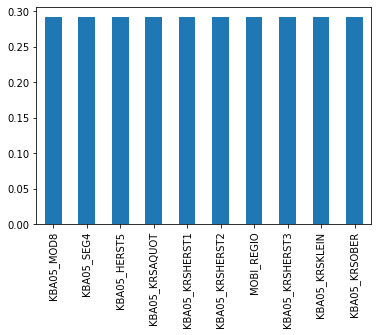

In [20]:
plot_nans(customers)

<AxesSubplot:>

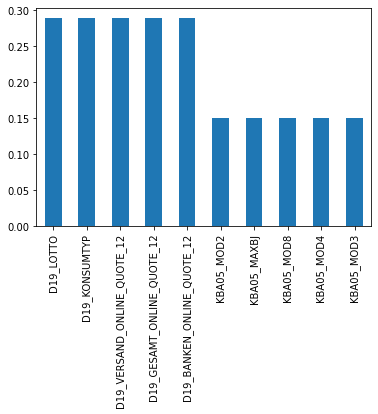

In [21]:
plot_nans(azdias)

## Normalize data according to documentation

In [22]:
def data_cleaning(df):
    '''
    input:
        df - Dataframe to clean
    
    output:
        df - Cleaned dataframe
    '''
    # Replace Xs with nan. Documentation has no X or XX values
    exp_clean_xs = lambda x: np.nan if x == 'X' or x == 'XX' else x
    
    for name in df.columns:
        df[name] = df[name].apply(exp_clean_xs)
            
    # Convert data types to number or object according to documentation
    
    for name in df.columns:
        if name not in ['CAMEO_DEU_2015','OST_WEST_KZ']:
            df[name] = pd.to_numeric(df[name], downcast='integer')
            
    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015','OST_WEST_KZ'])
    
    # Convert LNR as index column
    
    df = df.set_index('LNR')
            
    return df

customers = data_cleaning(customers)
azdias = data_cleaning(azdias)

### Convert unknown variables to nulls

Some variables have 1 or more values for describing unknown variables. Criteria will be unified to keep them as nulls

In [23]:
unknown_variables = excel_file[excel_file['Meaning'].str.contains('unknown')]\
    .assign(split_val=excel_file['Value'].str.split(',')).explode('split_val')
unknown_variables.Value = unknown_variables.split_val.combine_first(unknown_variables.Value)
unknown_variables = unknown_variables[['Attribute','Value']]

unknown_variables.tail(5)

,Attribute,Value
2238,WACHSTUMSGEBIET_NB,0
2244,W_KEIT_KIND_HH,-1
2244,W_KEIT_KIND_HH,0
2251,ZABEOTYP,-1
2251,ZABEOTYP,9


In [24]:
def normalize_unknown(df, unknown_variables_df):
    '''
    The function will normalize all unknown variables to nulls.
    
        input:
            df - Target dataframe for normalization
            unknown_variables_df - Dataframe with unknown vars
        
        output:
            df - Normalized dataframe
    '''
    for i in range(unknown_variables_df.shape[0]):
        attribute = unknown_variables_df.iloc[i,0]
        value = int(unknown_variables_df.iloc[i,1])

        try:
            exp = lambda x: np.nan if x == value else x
            df[attribute]= df[attribute].apply(exp)
        except:
            print("{} was not found in the DF".format(attribute))
    
    return df

In [25]:
customers = normalize_unknown(customers, unknown_variables)
customers.head()

BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_KZ was not found in the DF
SOHO_FLAG was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF


,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,10.0,1.0,0.0,2.0,0.0,3.0,1.0,5.0,0,...,0,0,0,0,0,0,0,0,0,1
9628,NaN,11.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
143872,NaN,6.0,1.0,0.0,1.0,0.0,7.0,5.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
143873,1.0,8.0,0.0,NaN,0.0,0.0,7.0,4.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
143874,NaN,20.0,7.0,0.0,4.0,0.0,3.0,7.0,6.0,1,...,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:>

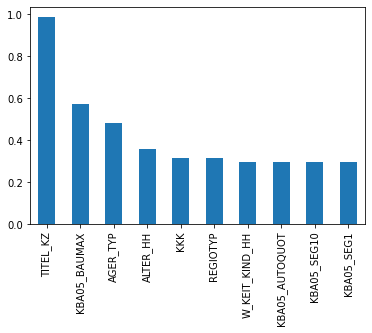

In [26]:
plot_nans(customers)

In [27]:
azdias = normalize_unknown(azdias, unknown_variables)
azdias.head()

BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_KZ was not found in the DF
SOHO_FLAG was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF


,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,...,0,0,0,0,0,0,0,0,0,0
910220,NaN,NaN,11.0,0.0,2.0,0.0,6.0,8.0,5.0,0,...,0,0,0,0,0,0,0,0,0,1
910225,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4.0,3.0,0,...,0,0,0,0,0,0,0,0,0,1
910226,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
910241,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6.0,5.0,3,...,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:>

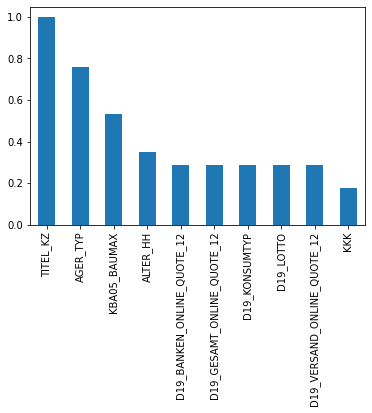

In [28]:
plot_nans(azdias)

In [29]:
def drop_nans(df, threshold = 0.9):
    '''
        Drop columns with more than 90% of nulls
        input:
            df - Dataframe to be analyzed
            
        output:
            df - Dataframe without columns with more than 90% of nulls
    '''
    # Get nans percentage
    frame_threshold = ((df.isnull().sum()/df.shape[0]).sort_values(ascending=False)>=threshold).to_frame()
    
    # Get col names that are above the threshold
    list_colnames = frame_threshold.loc[frame_threshold[0]==True].index.to_list()
    
    try:
        df = df.drop(columns=list_colnames)
        print("The columns below threshold: {} were removed.".format(list_colnames))
    except:
        print("Error! No columns to remove")
        
    return df

In [30]:
customers = drop_nans(customers)
azdias = drop_nans(azdias)

The columns below threshold: ['TITEL_KZ'] were removed.
The columns below threshold: ['TITEL_KZ'] were removed.


In [31]:
customers.describe()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
count,99545.000000,122905.000000,141725.000000,139542.000000,145056.000000,145056.000000,141693.000000,141098.000000,188439.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,1.588267,13.397966,4.965863,0.067413,2.267828,0.020392,4.301758,4.348963,3.677928,0.091040,...,0.019775,0.014615,0.011510,0.005338,0.004785,0.005150,0.010211,0.007868,0.059185,0.680306
std,0.713589,4.365868,14.309694,0.545576,1.390620,0.152234,2.114614,2.375612,1.813975,0.416684,...,0.139228,0.120006,0.106668,0.072865,0.069006,0.071578,0.100534,0.088355,0.235972,0.466359
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,10.000000,1.000000,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,13.000000,1.000000,0.000000,2.000000,0.000000,5.000000,4.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,17.000000,4.000000,0.000000,3.000000,0.000000,6.000000,6.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.000000,21.000000,523.000000,23.000000,21.000000,5.000000,7.000000,9.000000,6.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
def impute_median(df):
    '''
        Impute with median the DF
        
        input:
            df - Dataframe to be imputed
        output: 
            df - Imputed Dataframe
    '''
    exp = lambda x: x.fillna(x.median())
    df = df.apply(exp,axis=0)
    
    return df

customers = impute_median(customers)
azdias = impute_median(azdias)

customers.describe()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,1.786144,13.255213,3.932722,0.049084,2.202711,0.015434,4.483773,4.256914,3.683327,0.091040,...,0.019775,0.014615,0.011510,0.005338,0.004785,0.005150,0.010211,0.007868,0.059185,0.680306
std,0.553897,3.501421,12.427926,0.466499,1.215259,0.132730,1.843885,2.044144,1.799180,0.416684,...,0.139228,0.120006,0.106668,0.072865,0.069006,0.071578,0.100534,0.088355,0.235972,0.466359
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,11.000000,1.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,13.000000,1.000000,0.000000,2.000000,0.000000,5.000000,4.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,15.000000,2.000000,0.000000,3.000000,0.000000,6.000000,6.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.000000,21.000000,523.000000,23.000000,21.000000,5.000000,7.000000,9.000000,6.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
from sklearn.preprocessing import StandardScaler

def scale_features(df):
    '''
        Scale dataframe features for unsupervised and machine learning algorithms.
        input:
            df - Dataframe to be scaled
        output:
            df - Scaled Dataframe
    '''
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    return df_scaled
    

# Apply feature scaling 

customers_scaled = scale_features(customers)
azdias_scaled = scale_features(azdias)
azdias

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
910215,2.0,16.0,4.0,0.0,1.0,0.0,5.0,6.0,2.0,0,...,0,0,0,0,0,0,0,0,0,0
910220,2.0,16.0,11.0,0.0,2.0,0.0,6.0,8.0,5.0,0,...,0,0,0,0,0,0,0,0,0,1
910225,2.0,17.0,10.0,0.0,1.0,0.0,2.0,4.0,3.0,0,...,0,0,0,0,0,0,0,0,0,1
910226,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
910241,2.0,20.0,3.0,0.0,4.0,0.0,2.0,6.0,5.0,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825761,2.0,17.0,15.0,0.0,1.0,0.0,6.0,7.0,5.0,0,...,0,0,0,0,0,0,0,0,0,1
825771,2.0,16.0,11.0,0.0,1.0,0.0,7.0,9.0,4.0,0,...,0,0,0,0,0,0,1,0,0,1
825772,2.0,17.0,3.0,0.0,0.0,0.0,5.0,4.0,4.0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
import gc
gc.collect()

20

# Refactorization of the Previous Steps

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

excel_file = pd.read_excel('../files/DIAS Attributes - Values 2017.xlsx', sheet_name='Tabelle1', header=1, usecols=[1,2,3,4],
                          dtype='object')

def drop_nans(df, threshold = 0.9):
    '''
        Drop columns with more than 90% of nulls
        input:
            df - Dataframe to be analyzed
            
        output:
            df - Dataframe without columns with more than 90% of nulls
    '''
    # Get nans percentage
    frame_threshold = ((df.isnull().sum()/df.shape[0]).sort_values(ascending=False)>=threshold).to_frame()
    
    # Get col names that are above the threshold
    list_colnames = frame_threshold.loc[frame_threshold[0]==True].index.to_list()
    
    try:
        df = df.drop(columns=list_colnames)
        print("The columns below threshold: {} were removed.".format(list_colnames))
    except:
        print("Error! No columns to remove")
        
    return df


def impute_median(df):
    '''
        Impute with median the DF
        
        input:
            df - Dataframe to be imputed
        output: 
            df - Imputed Dataframe
    '''
    exp = lambda x: x.fillna(x.median())
    df = df.apply(exp,axis=0)
    
    return df


def scale_features(df):
    '''
        Scale dataframe features for unsupervised and machine learning algorithms.
        input:
            df - Dataframe to be scaled
        output:
            df - Scaled Dataframe
    '''
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled,index=df.index, columns=df.columns)
    
    return df_scaled

def data_preprocessing(df, documentation_df):
    '''
        Data cleaning and preparation.
        input:
            df - Dataframe to be preprocessed
            documentation_df - Excel documentation file provided
        
        output:
            df - Processed dataframe
    '''
    
    # Process documentation file
    documentation_df = documentation_df.fillna(method='ffill')
    documentation_df.Attribute = documentation_df.Attribute.str.upper().str.strip()
    documentation_df.Attribute = documentation_df.Attribute.str.replace(r'\_RZ','')
    documentation_df.Meaning = documentation_df.Meaning.str.lower().str.strip()
    
    # Get documentation column names. This will be used for dropping from the dataframes
    # the columns that do not exist in the documentation.
    docs_columns = set(documentation_df.Attribute)
    
    # Get df column names. This will be used to compare to the documentation columns
    df_columns = set(df.columns)
    
    # Get df columns to be dropped
    drop_target_df_cols = df_columns.difference(docs_columns)
    
    # Drop columns that do not exist in the documentation
    '''
    # Columns that will be ignored for removal
    
    skipped_columns = {'LNR'}# {'PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP','LNR'} 
    
    for value in skipped_columns:
        try:
            drop_target_df_cols.remove(value)
        except:
            continue
    '''
    print("Old Dataframe Shape: {}".format(df.shape))
    
    # Drop columns from dataframe
    try:
        df = df.drop(columns=drop_target_df_cols)
        print("\nSuccesfully removed {} columns!".format(len(drop_target_df_cols)))
    except:
        print("\nError! Check that column names exist in the dataframe", )
    
    
    # Replace Xs with nan in the df. Documentation has no X or XX values
    exp_clean_xs = lambda x: np.nan if x == 'X' or x == 'XX' else x
    
    for name in df.columns:
        df[name] = df[name].apply(exp_clean_xs)
            
    # Convert data types to number or object according to documentation
    
    for name in df.columns:
        if name not in ['CAMEO_DEU_2015','OST_WEST_KZ']:
            df[name] = pd.to_numeric(df[name], downcast='integer')
            
    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015','OST_WEST_KZ'])
    '''
    # Convert LNR as index column
    
    df = df.set_index('LNR')
    '''
    # Get unknown variable values from the documentation
    
    unknown_variables = documentation_df[documentation_df['Meaning'].str.contains('unknown')]\
        .assign(split_val=documentation_df['Value'].str.split(',')).explode('split_val')
    unknown_variables.Value = unknown_variables.split_val.combine_first(unknown_variables.Value)
    unknown_variables = unknown_variables[['Attribute','Value']]
    
    # Convert unknown variables to null
    
    for i in range(unknown_variables.shape[0]):
        attribute = unknown_variables.iloc[i,0]
        value = int(unknown_variables.iloc[i,1])

        try:
            exp = lambda x: np.nan if x == value else x
            df[attribute]= df[attribute].apply(exp)
        except:
            print("{} was not found in the DF".format(attribute))
    
    # Drop columns with more than 90% of nulls.
    df = drop_nans(df)
    
    # Impute the columns with the median
    df = impute_median(df)
    
    # Scale features
    df = scale_features(df)
    
    return df

In [4]:
customers_scaled = data_preprocessing(customers, excel_file)
azdias_scaled = data_preprocessing(azdias, excel_file)

Old Dataframe Shape: (191652, 369)

Succesfully removed 64 columns!
BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_KZ was not found in the DF
SOHO_FLAG was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
WACHSTUMSGEBIET_NB was not found in the DF
The columns below threshold: ['TITEL_KZ'] were removed.
Old Dataframe Shape: (891221, 366)

Succesfully removed 61 columns!
BIP_FLAG was not found in the DF
CAMEO_DEUINTL_2015 was not found in the DF
D19_KK_KUNDENTYP was not found in the DF
GEOSCORE_KLS7 was not found in the DF
GEOSCORE_KLS7 was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
HAUSHALTSSTRUKTUR was not found in the DF
KBA13_CCM_1400_2500 was not found in the DF
OST_WEST_K

In [5]:
from sklearn.decomposition import PCA

def principal_components(df, n_components):
    n_components = n_components
    whiten = False
    random_state = 2018

    pca = PCA(n_components=n_components, whiten=whiten, \
              random_state=random_state)

    train_index = range(0,len(df))
    X_train_PCA = pca.fit_transform(df)
    X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
    
    print("Variance Explained by all {} principal components: ".format(X_train_PCA.shape[1]), \
      sum(pca.explained_variance_ratio_))
    
    return X_train_PCA, pca

In [6]:
X_train_PCA, pca = principal_components(azdias_scaled, azdias_scaled.shape[1])

Variance Explained by all 348 principal components:  1.0


### Component Reduction

The rule of thumb: Keep values that have a variance equal or greater than the mean variance. After running the following code, 101 components were chosen.

In [7]:
# Rule of thumb: Keep values that have a variance equal or greater than the mean variance.
# We keep 101 components

importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

tot_components = (pca.explained_variance_ratio_>=pca.explained_variance_ratio_.mean()).sum()

print('Rule of thumb. Variance Captured by First {} Principal Components: {}'.format(tot_components,
    importanceOfPrincipalComponents.loc[:,0:tot_components-1].sum(axis=1).values))

Rule of thumb. Variance Captured by First 101 Principal Components: [0.70445475]


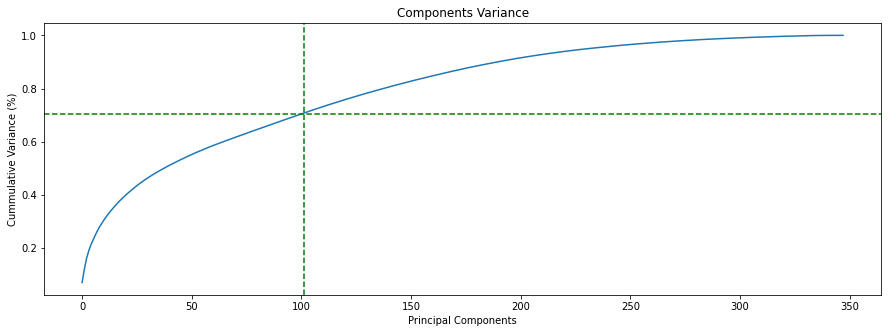

In [8]:
plt.figure(figsize=(15,5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axvline(x=tot_components, color='green',ls='--')
plt.axhline(y=importanceOfPrincipalComponents.loc[:,0:tot_components-1].sum(axis=1).values, color='green', ls='--')
plt.title("Components Variance")
plt.xlabel("Principal Components")
plt.ylabel("Cummulative Variance (%)")
plt.show()

### Get the principal components for the DFs

In [9]:
# Get the top components for each DF.
tot_components = 101

azdias_reduced, pca_azdias = principal_components(azdias_scaled, tot_components)
customers_reduced, pca_customer = principal_components(customers_scaled, tot_components)

Variance Explained by all 101 principal components:  0.6991107432882346
Variance Explained by all 101 principal components:  0.7020392975779165


In [10]:
def get_top_components(pca, df_columns, no_components):
    '''
        Get the top positive and negative correlated vars to the specified number of components
        input:
            pca - pca outcome from algorithm
            df_columns - column names from the original df
            n_components - number of components to analyze
        output:
            none
    '''
    for i in range(no_components):
        p_components = pd.DataFrame(pca.components_.transpose(), index =df_columns)
        print('\nVariance explained by component {}: {}%'.format(i, round(pca.explained_variance_ratio_[i]*100,2)))
        print("\n",p_components.iloc[:,i].sort_values(ascending=False).reset_index(name="Positive Corr").rename(columns={"index":"Attribute"}).head(3))
        print("\n",p_components.iloc[:,i].sort_values(ascending=False).reset_index(name="Negative Corr").rename(columns={"index":"Attribute"}).tail(3))

get_top_components(pca_azdias, azdias_scaled.columns, 3)


Variance explained by component 0: 7.03%

         Attribute  Positive Corr
0      MOBI_REGIO       0.138953
1     KBA05_ANTG1       0.131097
2  LP_STATUS_FEIN       0.130369

            Attribute  Negative Corr
345       PLZ8_ANTG4      -0.123030
346       PLZ8_ANTG3      -0.127667
347  CAMEO_DEUG_2015      -0.132350

Variance explained by component 1: 4.91%

                      Attribute  Positive Corr
0         KBA13_HERST_BMW_BENZ       0.176266
1               KBA13_MERCEDES       0.152268
2  KBA13_SEG_OBEREMITTELKLASSE       0.150966

                 Attribute  Negative Corr
345     KBA13_KMH_140_210      -0.127406
346  KBA13_SEG_KLEINWAGEN      -0.130633
347         KBA13_SITZE_5      -0.144998

Variance explained by component 2: 4.05%

             Attribute  Positive Corr
0   D19_GESAMT_ANZ_24       0.152227
1   D19_GESAMT_ANZ_12       0.145743
2  D19_VERSAND_ANZ_24       0.141041

                     Attribute  Negative Corr
345          D19_GESAMT_DATUM      -0.143378
